==================================================================================================================


1.	Accesarea și Descărcarea Datelor:


==================================================================================================================

◦	Navigați pe site-ul CAMS sau utilizați API-ul acestuia.

◦	Descărcați un set de date legat de calitatea aerului (de ex., PM2.5, emisii de CO2, niveluri de NO2) pentru o anumită regiune și perioadă de timp.

* *efectuat in Step1_Extragere si Step2_Preprocesare*   *

==================================================================================================================



2.	Curățarea și Preprocesarea Datelor:



==================================================================================================================

◦	Gestionați datele lipsă sau inconsistente.

◦	Convertiți datele temporale într-un format unificat.

◦	Extrageți caracteristicile relevante pentru analiză (de ex., nivelurile poluanților, coordonatele geografice).


Dimensiune inițială dataset: (1048872, 10)
  station_id country_name  region_code region_name        date  hour  month  \
0    PL0005R       Poland            5    Region-5  2024-01-17     0      1   
1    PL0005R       Poland            5    Region-5  2024-01-17     1      1   
2    PL0005R       Poland            5    Region-5  2024-01-17     2      1   
3    PL0005R       Poland            5    Region-5  2024-01-17     3      1   
4    PL0005R       Poland            5    Region-5  2024-01-17     4      1   

  day_of_week species  conc_raw_micrograms_per_m3  
0   Wednesday     NO2                         4.7  
1   Wednesday     NO2                         4.7  
2   Wednesday     NO2                         4.4  
3   Wednesday     NO2                         3.8  
4   Wednesday     NO2                         3.6  

Dimensiune finală dataset: (1048872, 14)
  station_id country_name  region_code region_name species  \
0    PL0005R       Poland            5    Region-5     NO2   
1   

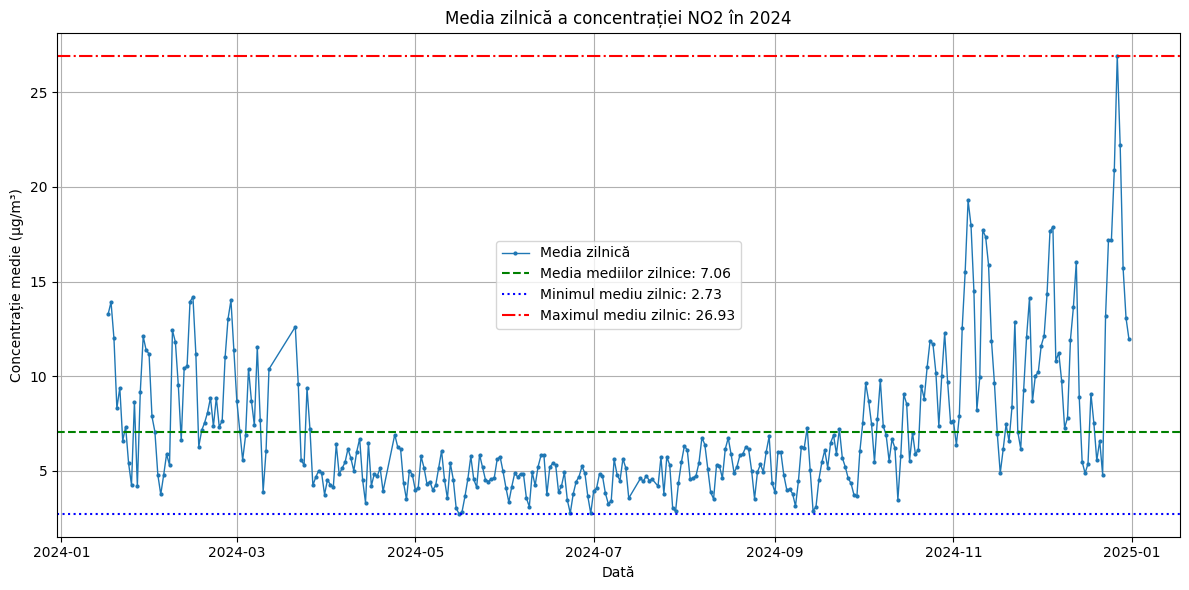

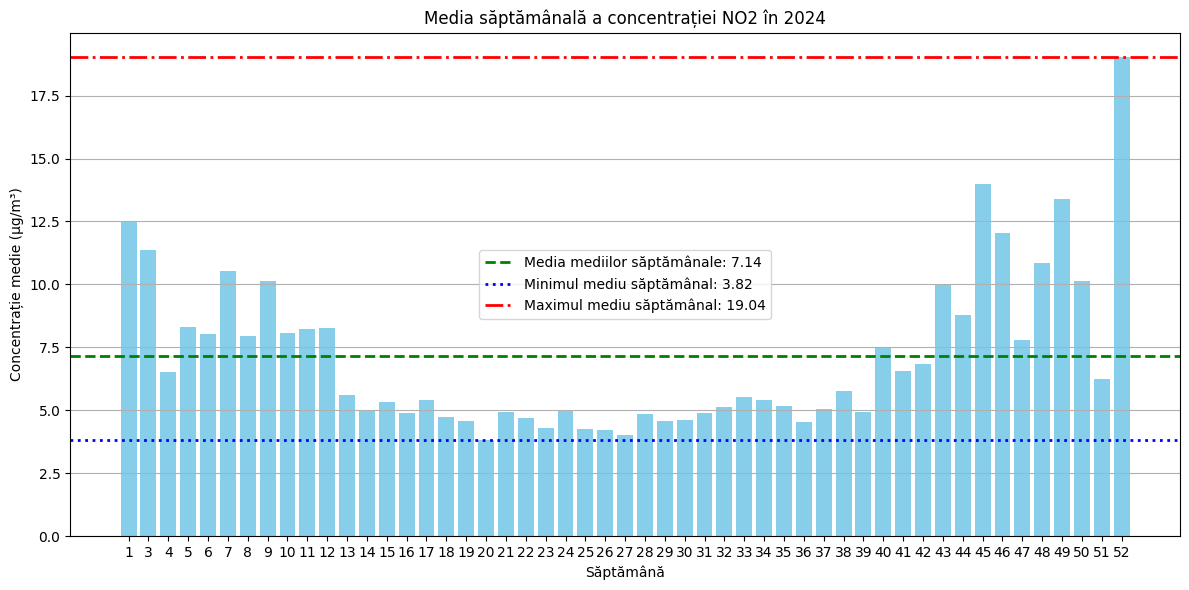

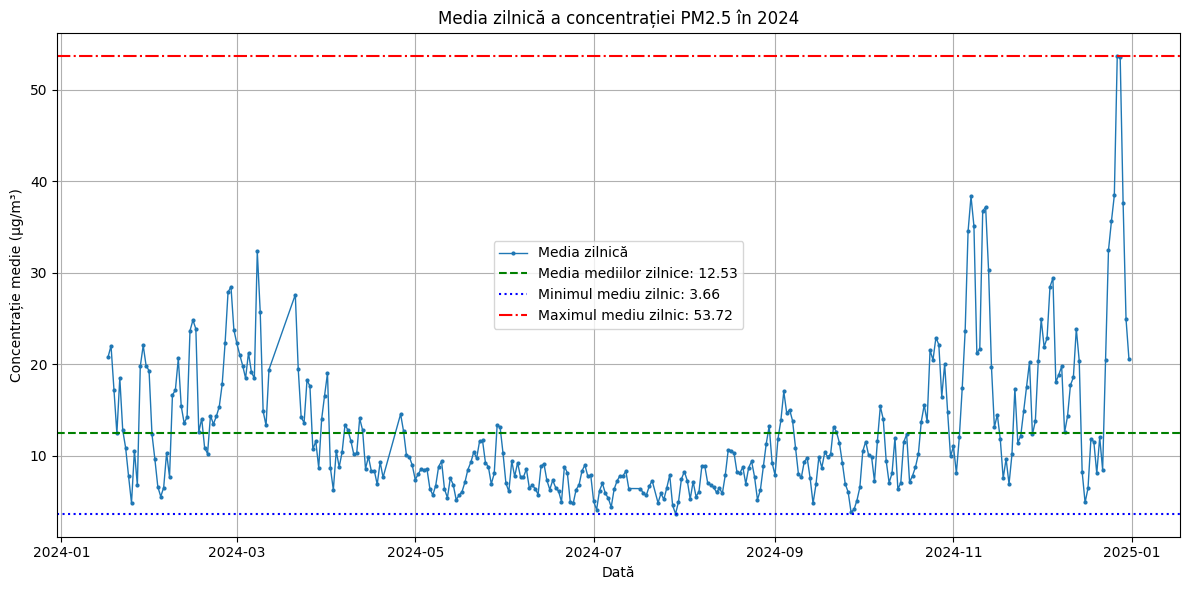

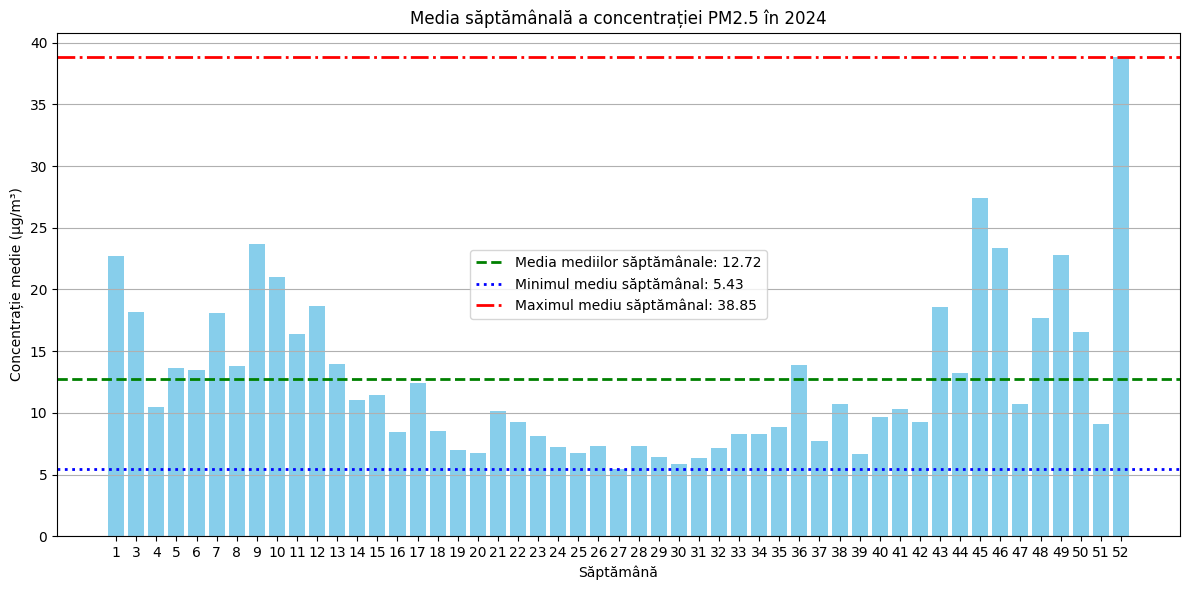

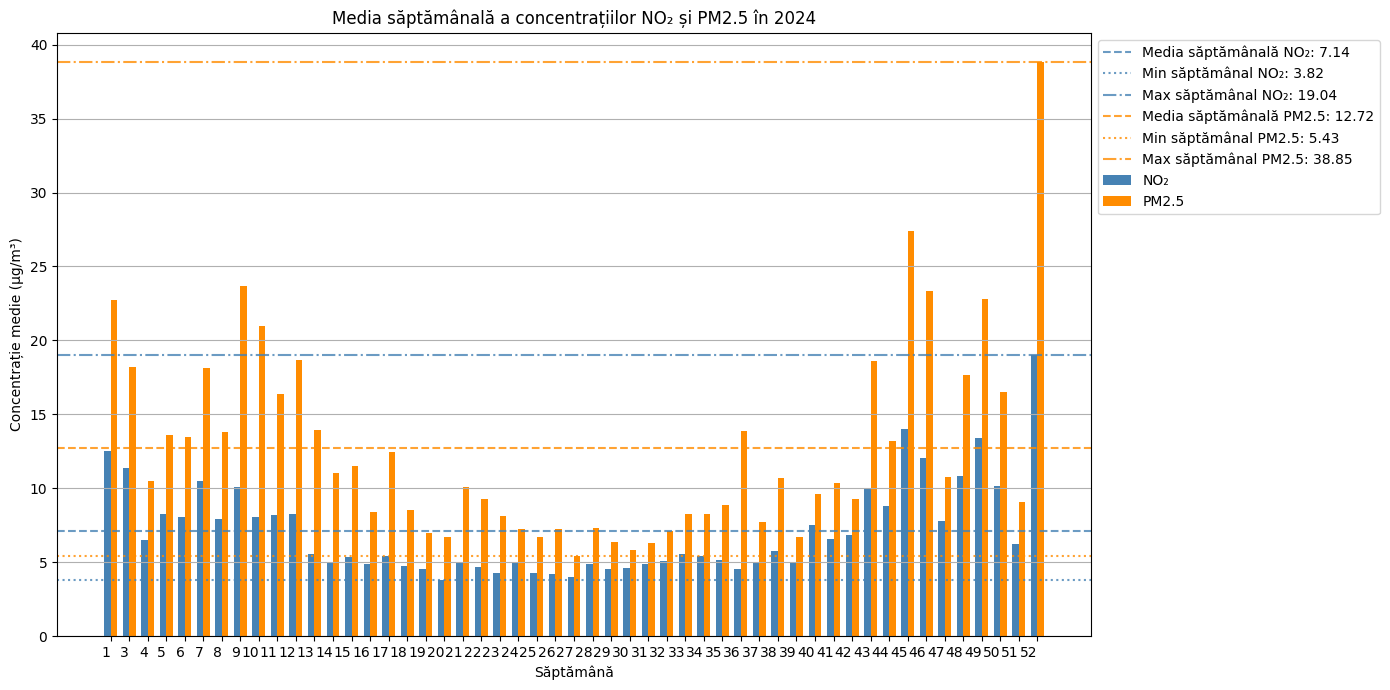


TABELE FINALE CU REZULTATELE AGREGATE

Media săptămânală combinată NO₂ și PM2.5:
           NO2 (µg/m³)  PM2.5 (µg/m³)
year_week                            
2024-W01         12.51          22.75
2024-W03         11.38          18.21
2024-W04          6.51          10.49
2024-W05          8.29          13.62
2024-W06          8.04          13.45
2024-W07         10.52          18.12
2024-W08          7.95          13.78
2024-W09         10.12          23.67
2024-W10          8.06          21.01
2024-W11          8.21          16.37
2024-W12          8.27          18.65
2024-W13          5.59          13.92
2024-W14          4.95          11.01
2024-W15          5.35          11.48
2024-W16          4.89           8.41
2024-W17          5.43          12.43
2024-W18          4.73           8.55
2024-W19          4.56           6.99
2024-W20          3.82           6.72
2024-W21          4.92          10.12
2024-W22          4.71           9.27
2024-W23          4.29           8.12
2024-W

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Încărcarea dataset-ului
df = pd.read_csv("air_quality_poland_2024_processed.csv", sep=";")

print("Dimensiune inițială dataset:", df.shape)
print(df.head())

# ============================================================
# Curățarea datelor
# ============================================================

# 1. Gestionarea datelor lipsă: eliminarea rândurilor cu valori lipsă în coloanele esențiale
essential_columns = [
    "station_id",
    "date",
    "hour",
    "species",
    "conc_raw_micrograms_per_m3"
]
df = df.dropna(subset=essential_columns)

# 2. Conversii de tip pentru consistență
df["hour"] = df["hour"].astype(int)
df["month"] = df["month"].astype(int)
df["conc_raw_micrograms_per_m3"] = pd.to_numeric(df["conc_raw_micrograms_per_m3"], errors='coerce')

# 3. Gestionarea valorilor inconsistente: eliminarea concentrațiilor negative sau invalide
df = df[df["conc_raw_micrograms_per_m3"] >= 0]

# 4. Verificarea și corectarea datelor temporale inconsistente (ex: ore invalide)
df = df[(df["hour"] >= 0) & (df["hour"] < 24)]

# ============================================================
# Preprocesarea datelor temporale
# ============================================================

# 1. Conversia coloanei 'date' în format datetime
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors='coerce')

# 2. Eliminarea rândurilor cu date invalide după conversie
df = df.dropna(subset=["date"])

# 3. Crearea timestamp-ului complet
df["datetime"] = df["date"] + pd.to_timedelta(df["hour"], unit="h")

# 4. Extracția informațiilor temporale suplimentare
df["year"] = df["datetime"].dt.year
df["day"] = df["datetime"].dt.day
df["weekday_num"] = df["datetime"].dt.weekday  # 0 = Luni, 6 = Duminică
df["week"] = df["datetime"].dt.isocalendar().week  # Numărul săptămânii

# ============================================================
# Extracția caracteristicilor relevante
# ============================================================

# Selectăm caracteristicile relevante, inclusiv cele geografice și temporale
features_df = df[[
    "station_id",
    "country_name",
    "region_code",
    "region_name",
    "species",
    "conc_raw_micrograms_per_m3",
    "datetime",
    "hour",
    "day_of_week",
    "month",
    "year",
    "day",
    "weekday_num",
    "week"
]]

# ============================================================
# Verificare și salvare dataset curățat
# ============================================================

print("\nDimensiune finală dataset:", features_df.shape)
print(features_df.head())

features_df.to_csv("poland_2024_clean.csv", index=False)
print("\n✔ Datele au fost curățate și preprocesate cu succes!")

# ============================================================
# Informații descriptive despre dataset
# ============================================================

print("=" * 70)
print("INFORMAȚII DATASET")
print("=" * 70)

print(f"\nDimensiune: {features_df.shape[0]:,} rânduri × {features_df.shape[1]} coloane")
print(f"\nPerioadă analizată: {features_df['datetime'].min()} → {features_df['datetime'].max()}")
print(f"\nStații de monitorizare: {features_df['station_id'].nunique()}")
print(f"Regiuni: {features_df['region_name'].nunique()}")
print(f"Poluanți monitorizați: {features_df['species'].unique()}")

# ============================================================
# Grafice ilustrative îmbunătățite
# ============================================================

# Definim poluanții de interes (NO2 și PM2.5, conform exemplelor din dataset)
pollutants = ["NO2", "PM2.5"]

# 1. Grafice zilnice separate pentru fiecare poluant
for pollutant in pollutants:
    if pollutant in features_df["species"].unique():
        df_pollutant = features_df[features_df["species"] == pollutant]
        
        # Media zilnică
        df_daily = (
            df_pollutant
            .groupby(df_pollutant["datetime"].dt.date)["conc_raw_micrograms_per_m3"]
            .mean()
            .reset_index()
            .rename(columns={"datetime": "date"})
        )
        df_daily["date"] = pd.to_datetime(df_daily["date"])
        
        # === Calcul statistici DOAR pe mediile zilnice ===
        daily_mean = df_daily["conc_raw_micrograms_per_m3"].mean()
        daily_min = df_daily["conc_raw_micrograms_per_m3"].min()
        daily_max = df_daily["conc_raw_micrograms_per_m3"].max()
        
        plt.figure(figsize=(12, 6))
        plt.plot(df_daily["date"], df_daily["conc_raw_micrograms_per_m3"], 
                 marker='o', linestyle='-', linewidth=1, markersize=2, label='Media zilnică')
        
        plt.axhline(y=daily_mean, color='green', linestyle='--', 
                    label=f'Media mediilor zilnice: {daily_mean:.2f}')
        plt.axhline(y=daily_min, color='blue', linestyle=':', 
                    label=f'Minimul mediu zilnic: {daily_min:.2f}')
        plt.axhline(y=daily_max, color='red', linestyle='-.', 
                    label=f'Maximul mediu zilnic: {daily_max:.2f}')
        
        plt.title(f"Media zilnică a concentrației {pollutant} în 2024")
        plt.xlabel("Dată")
        plt.ylabel("Concentrație medie (µg/m³)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 2. Media săptămânală
        df_weekly = (
            df_pollutant
            .groupby(["year", "week"])["conc_raw_micrograms_per_m3"]
            .mean()
            .reset_index()
        )
        df_weekly["week_label"] = df_weekly["week"].astype(str)
        
        # === Calcul statistici DOAR pe mediile săptămânale ===
        weekly_mean = df_weekly["conc_raw_micrograms_per_m3"].mean()
        weekly_min = df_weekly["conc_raw_micrograms_per_m3"].min()
        weekly_max = df_weekly["conc_raw_micrograms_per_m3"].max()
        
        plt.figure(figsize=(12, 6))
        plt.bar(df_weekly["week_label"], df_weekly["conc_raw_micrograms_per_m3"], color='skyblue')
        
        # Adăugăm liniile orizontale bazate doar pe mediile săptămânale
        plt.axhline(y=weekly_mean, color='green', linestyle='--', linewidth=2,
                    label=f'Media mediilor săptămânale: {weekly_mean:.2f}')
        plt.axhline(y=weekly_min, color='blue', linestyle=':', linewidth=2,
                    label=f'Minimul mediu săptămânal: {weekly_min:.2f}')
        plt.axhline(y=weekly_max, color='red', linestyle='-.', linewidth=2,
                    label=f'Maximul mediu săptămânal: {weekly_max:.2f}')
        
        plt.title(f"Media săptămânală a concentrației {pollutant} în 2024")
        plt.xlabel("Săptămână")
        plt.ylabel("Concentrație medie (µg/m³)")
        plt.xticks(rotation=0, ha='center')
        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

    else:
        print(f"Poluantul {pollutant} nu există în dataset.")

# 2. Bar chart combinat săptămânal pentru ambii poluanți
if all(p in features_df["species"].unique() for p in pollutants):
    df_all_weekly = features_df[features_df['species'].isin(pollutants)] \
        .groupby(['species', 'year', 'week'])['conc_raw_micrograms_per_m3'].mean() \
        .reset_index()
    
    # Pivot pentru bar-uri grupate
    df_pivot = df_all_weekly.pivot(index=['year', 'week'], columns='species', 
                                   values='conc_raw_micrograms_per_m3').reset_index().fillna(0)
    
    # Etichete X: doar numărul săptămânii
    df_pivot['week_label'] = df_pivot['week'].astype(str)
    
    # === Calcul statistici DOAR pe mediile săptămânale ===
    weekly_mean_no2 = df_pivot['NO2'].mean()
    weekly_min_no2 = df_pivot['NO2'].min()
    weekly_max_no2 = df_pivot['NO2'].max()
    
    weekly_mean_pm25 = df_pivot['PM2.5'].mean()
    weekly_min_pm25 = df_pivot['PM2.5'].min()
    weekly_max_pm25 = df_pivot['PM2.5'].max()
    
    # Pregătire plot
    width = 0.35
    ind = np.arange(len(df_pivot))
    
    plt.figure(figsize=(14, 7))
    plt.bar(ind - width/2, df_pivot['NO2'], width, label='NO₂', color='steelblue')
    plt.bar(ind + width/2, df_pivot['PM2.5'], width, label='PM2.5', color='darkorange')
    
    # Linii orizontale bazate doar pe mediile săptămânale
    plt.axhline(y=weekly_mean_no2, color='steelblue', linestyle='--', alpha=0.8,
                label=f'Media săptămânală NO₂: {weekly_mean_no2:.2f}')
    plt.axhline(y=weekly_min_no2, color='steelblue', linestyle=':', alpha=0.8,
                label=f'Min săptămânal NO₂: {weekly_min_no2:.2f}')
    plt.axhline(y=weekly_max_no2, color='steelblue', linestyle='-.', alpha=0.8,
                label=f'Max săptămânal NO₂: {weekly_max_no2:.2f}')
    
    plt.axhline(y=weekly_mean_pm25, color='darkorange', linestyle='--', alpha=0.8,
                label=f'Media săptămânală PM2.5: {weekly_mean_pm25:.2f}')
    plt.axhline(y=weekly_min_pm25, color='darkorange', linestyle=':', alpha=0.8,
                label=f'Min săptămânal PM2.5: {weekly_min_pm25:.2f}')
    plt.axhline(y=weekly_max_pm25, color='darkorange', linestyle='-.', alpha=0.8,
                label=f'Max săptămânal PM2.5: {weekly_max_pm25:.2f}')
    
    plt.title("Media săptămânală a concentrațiilor NO₂ și PM2.5 în 2024")
    plt.xlabel("Săptămână")
    plt.ylabel("Concentrație medie (µg/m³)")
    plt.xticks(ind, df_pivot['week_label'], rotation=0, ha='right')
    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Nu toți poluanții sunt disponibili pentru graficul combinat.")




# ============================================================
# Afișare și salvare tabele finale cu toate agregările
# ============================================================

print("\n" + "="*80)
print("TABELE FINALE CU REZULTATELE AGREGATE")
print("="*80)

# 1. Tabel combinat săptămânal (folosit și în bar chart-ul combinat)
if 'df_pivot' in locals():
    weekly_combined_table = df_pivot.copy()
    weekly_combined_table['year_week'] = weekly_combined_table['year'].astype(str) + "-W" + weekly_combined_table['week'].astype(str).str.zfill(2)
    weekly_combined_table = weekly_combined_table.set_index('year_week')[['NO2', 'PM2.5']].round(2)
    weekly_combined_table.columns = ['NO2 (µg/m³)', 'PM2.5 (µg/m³)']
    
    print("\nMedia săptămânală combinată NO₂ și PM2.5:")
    print(weekly_combined_table)


# 2. Opțional: salvăm și mediile zilnice pentru ambii poluanți (dacă vrei tabel complet zilnic)
daily_tables = []
for pollutant in pollutants:
    if pollutant in features_df["species"].unique():
        df_pollutant = features_df[features_df["species"] == pollutant]
        df_daily = (
            df_pollutant
            .groupby(df_pollutant["datetime"].dt.date)["conc_raw_micrograms_per_m3"]
            .mean()
            .reset_index()
        )
        df_daily.columns = ["date", pollutant]
        df_daily["date"] = pd.to_datetime(df_daily["date"]).dt.strftime("%Y-%m-%d")
        df_daily[pollutant] = df_daily[pollutant].round(2)
        daily_tables.append(df_daily)

if daily_tables:
    daily_combined = daily_tables[0].merge(daily_tables[1], on="date", how="outer").fillna('-')
    daily_combined = daily_combined.sort_values("date")
    daily_combined = daily_combined.set_index("date")
    
    print("\n" + "="*80)
    print("Media zilnică combinată NO₂ și PM2.5 (primele și ultimele 20 de zile):")
    print(pd.concat([daily_combined.head(20), daily_combined.tail(20)]))

==================================================================================================================

3.	Analiza Datelor:

==================================================================================================================

◦	Calculați statistici descriptive de bază (medie, mediană, deviație standard) pentru nivelurile poluanților.




In [13]:
import pandas as pd

df = pd.read_csv("poland_2024_clean.csv")

# Grupare după poluant și calcul statistici multiple
pollutant_stats = (
    df.groupby("species")["conc_raw_micrograms_per_m3"]
    .agg(
        count=("count"),           # număr de măsurători
        mean=("mean"),             # media
        median=("median"),         # mediana
        std=("std"),               # deviația standard
        min=("min"),               # valoarea minimă
        max=("max"),               # valoarea maximă
        q25=lambda x: x.quantile(0.25),  # percentila 25
        q75=lambda x: x.quantile(0.75),  # percentila 75
        iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)  # interval interquartil
    )
    .reset_index()
)

# Rotunjim toate coloanele numerice la 2 zecimale pentru lizibilitate
numeric_cols = pollutant_stats.select_dtypes(include="float64").columns
pollutant_stats[numeric_cols] = pollutant_stats[numeric_cols].round(2)

# Opțional: redenumim coloanele pentru o afișare mai clară
pollutant_stats.columns = [
    "Poluant",
    "Nr. măsurători",
    "Media (µg/m³)",
    "Mediana (µg/m³)",
    "Dev. standard",
    "Minim (µg/m³)",
    "Maxim (µg/m³)",
    "Percentila 25",
    "Percentila 75",
    "IQR"
]

# Afișare tabel frumos
print("\n=== STATISTICI DESCRIPTIVE PE POLUANȚI ===")
print(pollutant_stats.to_string(index=False))


=== STATISTICI DESCRIPTIVE PE POLUANȚI ===
Poluant  Nr. măsurători  Media (µg/m³)  Mediana (µg/m³)  Dev. standard  Minim (µg/m³)  Maxim (µg/m³)  Percentila 25  Percentila 75  IQR
    NO2          794976           7.03              5.2           6.36            0.2           84.2            3.0            8.8  5.8
  PM2.5          253896          12.75              9.5          11.02            1.0          203.2            6.2           15.4  9.2


◦	Identificați tendințele în timp pentru un poluant selectat, utilizând analiza seriilor temporale.


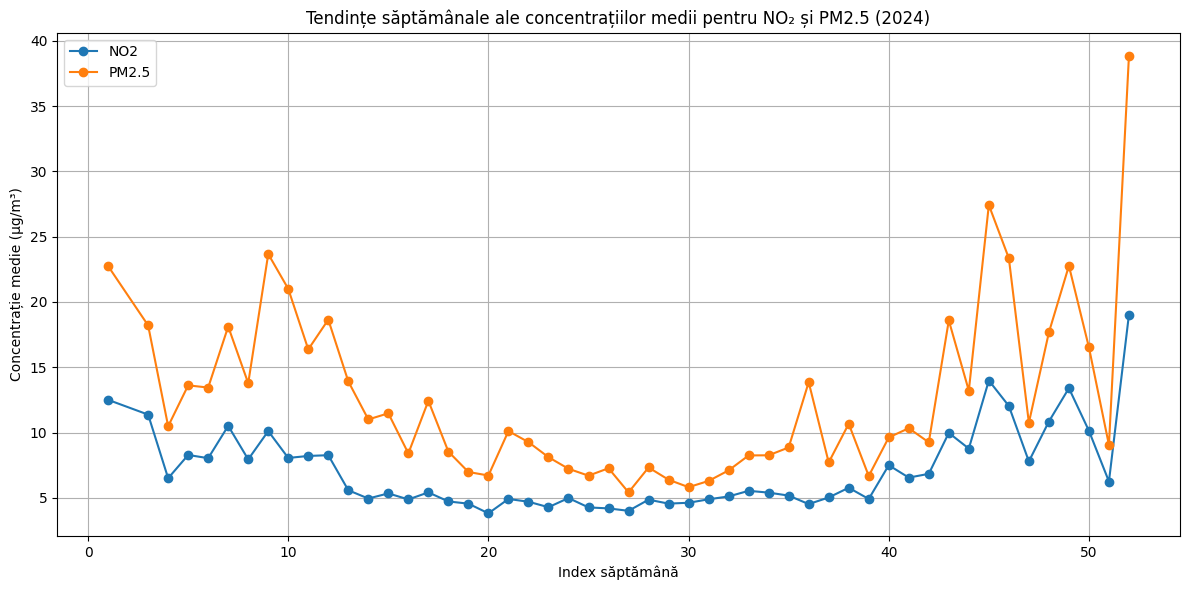

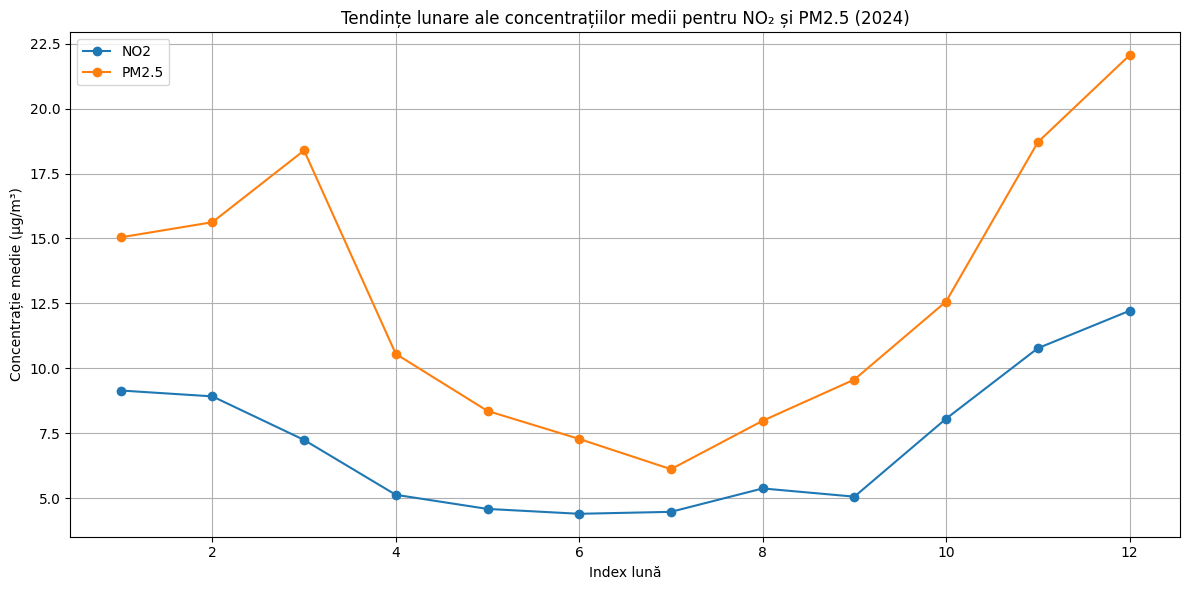


TABEL: Media săptămânală a concentrațiilor NO₂ și PM2.5
species      NO2  PM2.5
year_week              
2024-W01   12.51  22.75
2024-W03   11.38  18.21
2024-W04    6.51  10.49
2024-W05    8.29  13.62
2024-W06    8.04  13.45
2024-W07   10.52  18.12
2024-W08    7.95  13.78
2024-W09   10.12  23.67
2024-W10    8.06  21.01
2024-W11    8.21  16.37
2024-W12    8.27  18.65
2024-W13    5.59  13.92
2024-W14    4.95  11.01
2024-W15    5.35  11.48
2024-W16    4.89   8.41
2024-W17    5.43  12.43
2024-W18    4.73   8.55
2024-W19    4.56   6.99
2024-W20    3.82   6.72
2024-W21    4.92  10.12
2024-W22    4.71   9.27
2024-W23    4.29   8.12
2024-W24    4.99   7.23
2024-W25    4.28   6.71
2024-W26    4.20   7.27
2024-W27    4.01   5.43
2024-W28    4.87   7.33
2024-W29    4.57   6.40
2024-W30    4.63   5.83
2024-W31    4.90   6.30
2024-W32    5.12   7.11
2024-W33    5.54   8.25
2024-W34    5.41   8.27
2024-W35    5.18   8.86
2024-W36    4.53  13.86
2024-W37    5.04   7.72
2024-W38    5.78  10.68
2024-W3

In [37]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("poland_2024_clean.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Definim poluanții de interes
pollutants = ["NO2", "PM2.5"]
df_pollutants = df[df['species'].isin(pollutants)]

# ============================================================
#  Media săptămânală - Grafic combinat cu tendințe (line plot)
# ============================================================

# Calculăm media săptămânală pentru fiecare poluant
df_weekly = (
    df_pollutants
    .groupby(['species', 'year', 'week'])['conc_raw_micrograms_per_m3']
    .mean()
    .reset_index()
)

df_weekly['week_index'] = (df_weekly['year'] - df_weekly['year'].min()) * 52 + df_weekly['week']
df_weekly_pivot = df_weekly.pivot(index='week_index', columns='species', values='conc_raw_micrograms_per_m3').fillna(0)

# Grafic line plot pentru tendințe săptămânale
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    if pollutant in df_weekly_pivot.columns:
        plt.plot(df_weekly_pivot.index, df_weekly_pivot[pollutant], marker='o', label=pollutant)

plt.title("Tendințe săptămânale ale concentrațiilor medii pentru NO₂ și PM2.5 (2024)")
plt.xlabel("Index săptămână")
plt.ylabel("Concentrație medie (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# Media lunară - Grafic combinat cu tendințe (line plot)
# ============================================================

# Calculăm media lunară pentru fiecare poluant
df_monthly = (
    df_pollutants
    .groupby(['species', 'year', 'month'])['conc_raw_micrograms_per_m3']
    .mean()
    .reset_index()
)

df_monthly['month_index'] = (df_monthly['year'] - df_monthly['year'].min()) * 12 + df_monthly['month']
df_monthly_pivot = df_monthly.pivot(index='month_index', columns='species', values='conc_raw_micrograms_per_m3').fillna(0)

# Grafic line plot pentru tendințe lunare
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    if pollutant in df_monthly_pivot.columns:
        plt.plot(df_monthly_pivot.index, df_monthly_pivot[pollutant], marker='o', label=pollutant)

plt.title("Tendințe lunare ale concentrațiilor medii pentru NO₂ și PM2.5 (2024)")
plt.xlabel("Index lună")
plt.ylabel("Concentrație medie (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# ============================================================
# Afișare și salvare tabele cu rezultatele
# ============================================================

print("\n" + "="*80)
print("TABEL: Media săptămânală a concentrațiilor NO₂ și PM2.5")
print("="*80)

# Refacem pivotul cu etichete mai clare (an-săptămână)
df_weekly_table = df_weekly.copy()
df_weekly_table['year_week'] = df_weekly_table['year'].astype(str) + "-W" + df_weekly_table['week'].astype(str).str.zfill(2)
df_weekly_table = df_weekly_table.pivot(index='year_week', columns='species', values='conc_raw_micrograms_per_m3').round(2)
df_weekly_table = df_weekly_table[['NO2', 'PM2.5']].fillna('-')
print(df_weekly_table)

print("\n" + "="*80)
print("TABEL: Media lunară a concentrațiilor NO₂ și PM2.5")
print("="*80)

df_monthly_table = df_monthly.copy()
df_monthly_table['year_month'] = df_monthly_table['year'].astype(str) + "-" + df_monthly_table['month'].astype(str).str.zfill(2)
df_monthly_table = df_monthly_table.pivot(index='year_month', columns='species', values='conc_raw_micrograms_per_m3').round(2)
df_monthly_table = df_monthly_table[['NO2', 'PM2.5']].fillna('-')
print(df_monthly_table)

◦	Comparați nivelurile poluanților în diferite regiuni.

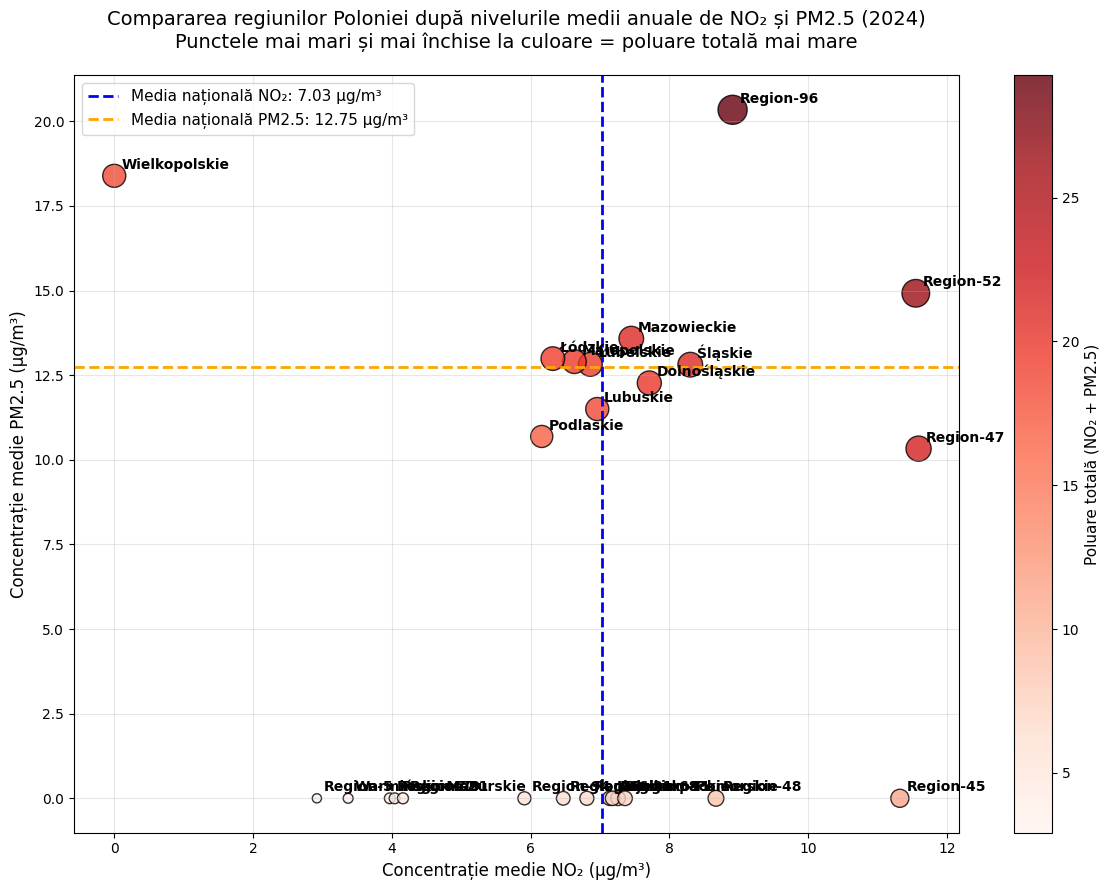

TABEL: Niveluri medii anuale pe regiuni (sortat după poluare totală)
species                NO2  PM2.5  Total
region_name                             
Region-96             8.91  20.34  29.25
Region-52            11.55  14.92  26.47
Region-47            11.59  10.33  21.92
Śląskie               8.30  12.81  21.11
Mazowieckie           7.45  13.58  21.03
Dolnośląskie          7.71  12.27  19.98
Lubelskie             6.86  12.82  19.68
Małopolskie           6.63  12.90  19.53
Łódzkie               6.32  12.99  19.31
Lubuskie              6.96  11.50  18.46
Wielkopolskie         0.00  18.39  18.39
Podlaskie             6.16  10.69  16.85
Region-45            11.32   0.00  11.32
Region-48             8.67   0.00   8.67
Region-71             7.36   0.00   7.36
Podkarpackie          7.26   0.00   7.26
Region-68             7.18   0.00   7.18
Kujawsko-Pomorskie    7.14   0.00   7.14
Region-31             6.81   0.00   6.81
Region-66             6.47   0.00   6.47
Region-94             5.91   

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1. Pregătire date (aceeași ca înainte)
# ============================================================

region_pollutant_stats = (
    features_df
    .groupby(["region_name", "species"])["conc_raw_micrograms_per_m3"]
    .mean()
    .reset_index()
)

region_stats_filtered = region_pollutant_stats[
    region_pollutant_stats["species"].isin(["NO2", "PM2.5"])
]

pivot_df = region_stats_filtered.pivot(
    index="region_name",
    columns="species",
    values="conc_raw_micrograms_per_m3"
).fillna(0).round(2)

# Poluare totală pentru dimensiunea punctelor
pivot_df["Total"] = pivot_df["NO2"] + pivot_df["PM2.5"]

# Mediile naționale
national_means = features_df[features_df["species"].isin(["NO2", "PM2.5"])] \
    .groupby("species")["conc_raw_micrograms_per_m3"].mean()

no2_national = national_means.get("NO2", 0).round(2)
pm25_national = national_means.get("PM2.5", 0).round(2)

# ============================================================
# 2. Scatter plot - Comparare regiuni NO₂ vs PM2.5
# ============================================================

plt.figure(figsize=(12, 9))

# Scatter plot cu dimensiune proporțională cu poluarea totală
scatter = plt.scatter(
    pivot_df["NO2"],
    pivot_df["PM2.5"],
    s=pivot_df["Total"] * 15,       # dimensiune punct mai mare dacă poluare totală mare
    c=pivot_df["Total"],
    cmap="Reds",
    alpha=0.8,
    edgecolors="black",
    linewidth=1
)

# Linii pentru mediile naționale (împart graficul în 4 cadrane)
plt.axvline(x=no2_national, color='blue', linestyle='--', linewidth=2,
            label=f'Media națională NO₂: {no2_national:.2f} µg/m³')
plt.axhline(y=pm25_national, color='orange', linestyle='--', linewidth=2,
            label=f'Media națională PM2.5: {pm25_national:.2f} µg/m³')

# Etichete pe fiecare punct (numele regiunii)
for region, row in pivot_df.iterrows():
    plt.annotate(region,
                 (row["NO2"], row["PM2.5"]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=10, fontweight='bold',
                 ha='left')

# Setări grafic
plt.title("Compararea regiunilor Poloniei după nivelurile medii anuale de NO₂ și PM2.5 (2024)\n"
          "Punctele mai mari și mai închise la culoare = poluare totală mai mare",
          fontsize=14, pad=20)
plt.xlabel("Concentrație medie NO₂ (µg/m³)", fontsize=12)
plt.ylabel("Concentrație medie PM2.5 (µg/m³)", fontsize=12)
plt.legend(fontsize=11)

# Grilă și aspect
plt.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter)
cbar.set_label("Poluare totală (NO₂ + PM2.5)", fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================
# 3. Tabel sortat (opțional, rămâne util)
# ============================================================

pivot_display = pivot_df.sort_values("Total", ascending=False)[["NO2", "PM2.5"]].copy()
pivot_display["Total"] = pivot_df["Total"]

print("=" * 80)
print("TABEL: Niveluri medii anuale pe regiuni (sortat după poluare totală)")
print("=" * 80)
print(pivot_display.round(2).to_string())
print(f"\nMedii naționale: NO₂ = {no2_national:.2f} µg/m³ | PM2.5 = {pm25_national:.2f} µg/m³")
print("=" * 80)

==================================================================================================================

4.	Vizualizarea Datelor:

==================================================================================================================

◦	Creați grafice de serii temporale pentru a arăta tendințele poluanților în timp.




ANALIZĂ SERII TEMPORALE – POLUANȚI NO₂ ȘI PM2.5

📊 Procesare NO2...

📅 Tabel: Media zilnică și tendința pe 7 zile – NO2
----------------------------------------------------------------------
      date  daily_mean  rolling_mean_7 pollutant
2024-01-17       13.27           13.27       NO2
2024-01-18       13.91           13.59       NO2
2024-01-19       12.00           13.06       NO2
2024-01-20        8.30           11.87       NO2
2024-01-21        9.39           11.38       NO2
2024-01-22        6.60           10.58       NO2
2024-01-23        7.32           10.11       NO2
2024-01-24        5.41            8.99       NO2
2024-01-25        4.25            7.61       NO2
2024-01-26        8.64            7.13       NO2
2024-12-22        4.80            6.26       NO2
2024-12-23       13.16            7.44       NO2
2024-12-24       17.19            9.13       NO2
2024-12-25       17.19           10.29       NO2
2024-12-26       20.92           12.20       NO2
2024-12-27       26.93   

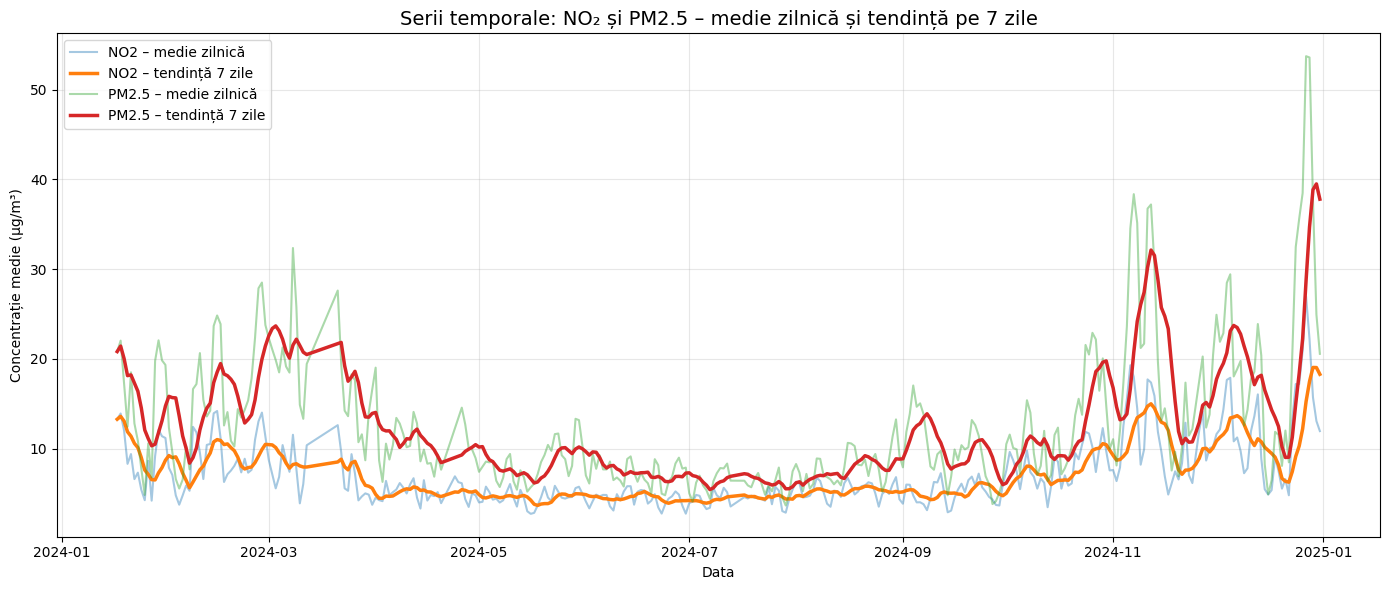


TABEL COMPLET: Media zilnică și tendința pe 7 zile (NO₂ + PM2.5)
Primele 15 și ultimele 15 zile:
      date pollutant  daily_mean  rolling_mean_7
2024-01-17       NO2       13.27           13.27
2024-01-17     PM2.5       20.81           20.81
2024-01-18       NO2       13.91           13.59
2024-01-18     PM2.5       22.03           21.42
2024-01-19       NO2       12.00           13.06
2024-01-19     PM2.5       17.24           20.03
2024-01-20       NO2        8.30           11.87
2024-01-20     PM2.5       12.45           18.13
2024-01-21     PM2.5       18.50           18.21
2024-01-21       NO2        9.39           11.38
2024-01-22       NO2        6.60           10.58
2024-01-22     PM2.5       12.80           17.31
2024-01-23       NO2        7.32           10.11
2024-01-23     PM2.5       10.86           16.39
2024-01-24     PM2.5        7.76           14.52
2024-12-24       NO2       17.19            9.13
2024-12-25     PM2.5       35.61           18.38
2024-12-25       NO2

In [32]:
# ============================================================
# Analiză serii temporale + afișare tabelară
# ============================================================

print("=" * 80)
print("ANALIZĂ SERII TEMPORALE – POLUANȚI NO₂ ȘI PM2.5")
print("=" * 80)

pollutants = ["NO2", "PM2.5"]

# Opțional: păstrăm graficul
plt.figure(figsize=(14, 6))

# Lista pentru a stoca tabelele finale (dacă vrei să le combini sau exporti mai târziu)
tables = []

for pollutant in pollutants:
    if pollutant not in features_df["species"].unique():
        print(f"⚠️ Poluantul {pollutant} nu există în dataset.")
        continue
    
    print(f"\n📊 Procesare {pollutant}...")
    
    df_pollutant = features_df[features_df["species"] == pollutant].copy()

    # Media zilnică
    daily_avg = (
        df_pollutant
        .groupby(df_pollutant["datetime"].dt.date)["conc_raw_micrograms_per_m3"]
        .mean()
        .reset_index()
    )
    daily_avg.columns = ["date", "daily_mean"]
    daily_avg["date"] = pd.to_datetime(daily_avg["date"])

    # Media mobilă pe 7 zile (tendință)
    daily_avg["rolling_mean_7"] = daily_avg["daily_mean"].rolling(window=7, min_periods=1).mean()

    # Rotunjim pentru lizibilitate
    daily_avg["daily_mean"] = daily_avg["daily_mean"].round(2)
    daily_avg["rolling_mean_7"] = daily_avg["rolling_mean_7"].round(2)

    # Adăugăm coloana cu poluantul
    daily_avg["pollutant"] = pollutant

    # Salvăm tabelul
    tables.append(daily_avg[["date", "pollutant", "daily_mean", "rolling_mean_7"]])

    # === Afișare tabelară pentru acest poluant ===
    print(f"\n📅 Tabel: Media zilnică și tendința pe 7 zile – {pollutant}")
    print("-" * 70)
    # Afișăm doar primele și ultimele 10 rânduri pentru a nu inunda consola
    display_df = pd.concat([daily_avg.head(10), daily_avg.tail(10)])
    print(display_df.to_string(index=False))

    # === Plot (opțional) ===
    plt.plot(daily_avg["date"], daily_avg["daily_mean"], 
             label=f"{pollutant} – medie zilnică", alpha=0.4, linewidth=1.5)
    plt.plot(daily_avg["date"], daily_avg["rolling_mean_7"], 
             label=f"{pollutant} – tendință 7 zile", linewidth=2.5)

# Finalizare grafic (dacă vrei să-l vezi)
plt.title("Serii temporale: NO₂ și PM2.5 – medie zilnică și tendință pe 7 zile", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Concentrație medie (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# Tabel combinat final (ambii poluanți)
# ============================================================

if tables:
    combined_table = pd.concat(tables, ignore_index=True)
    
    # Sortăm cronologic
    combined_table = combined_table.sort_values("date").reset_index(drop=True)

    print("\n" + "="*80)
    print("TABEL COMPLET: Media zilnică și tendința pe 7 zile (NO₂ + PM2.5)")
    print("="*80)
    print("Primele 15 și ultimele 15 zile:")
    display_combined = pd.concat([combined_table.head(15), combined_table.tail(15)])
    print(display_combined.to_string(index=False))

◦	Utilizați o hartă termică pentru a vizualiza concentrațiile poluanților pe o hartă geografică.


HARTĂ POLONIA - FIX Mazowieckie Split

✓ Date: 1,048,872 rânduri, Media: 8.41 ug/m3

📊 Top 5:
  Wielkopolskie................. 10.14 ug/m3
  Podkarpackie.................. 9.86 ug/m3
  Świętokrzyskie................ 9.39 ug/m3
  Lubuskie...................... 9.01 ug/m3
  Zachodniopomorskie............ 8.92 ug/m3

⏳ Descarc NUTS2...

✓ Polonia: 17 regiuni NUTS2

⏳ Normalizare cu FIX pentru Mazowieckie...

🔧 FIX Special pentru Mazowieckie:
   • 'mazowiecki regionalny' → 'mazowieckie'
   • 'warszawski stoleczny' → 'mazowieckie'

📋 Verificare matching:
GeoJSON unique: 16
Date unique: 16
Intersecție (match): 16

⏳ Merge...

✓ Matched: 17/17

📊 REZULTATE:
✓ Śląskie............................   7.08 ug/m3
✓ Kujawsko-Pomorskie.................   8.03 ug/m3
✓ Wielkopolskie......................  10.14 ug/m3
✓ Warmińsko-Mazurskie................   7.77 ug/m3
✓ Zachodniopomorskie.................   8.92 ug/m3
✓ Dolnośląskie.......................   6.58 ug/m3
✓ Opolskie.........................

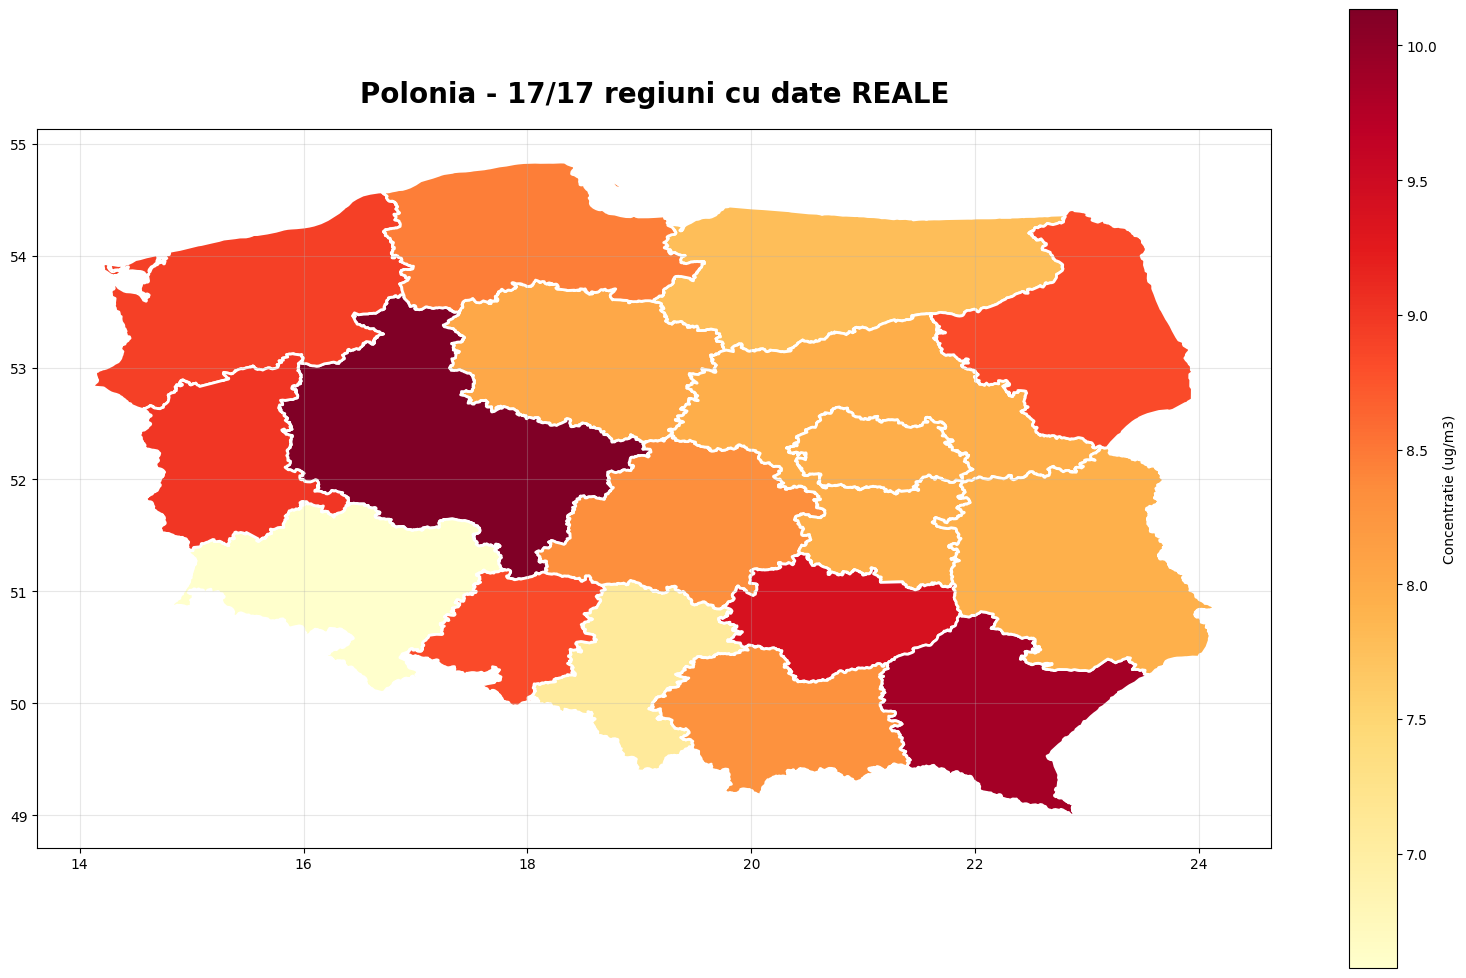

✓ HTML: harta_polonia_COMPLETE.html

✓ HARTĂ COMPLETĂ GENERATĂ!
📊 Regiuni NUTS2: 17
📊 Cu date REALE: 17/17
📊 Media națională: 8.41 ug/m3

🎉 PERFECT! TOATE regiunile au date!


In [24]:
# ============================================================================
# HARTĂ POLONIA - FIX FINAL MAZOWIECKIE
# ============================================================================

import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt

print("=" * 70)
print("HARTĂ POLONIA - FIX Mazowieckie Split")
print("=" * 70)

# ============================================================================
# PARTEA 1: DATE REALE
# ============================================================================

df = pd.read_csv('air_quality_poland_2024_processed.csv', sep=';')
total_avg = df['conc_raw_micrograms_per_m3'].mean()

print(f"\n✓ Date: {len(df):,} rânduri, Media: {total_avg:.2f} ug/m3")

all_poland_regions = [
    'Dolnośląskie', 'Kujawsko-Pomorskie', 'Lubelskie', 'Lubuskie',
    'Łódzkie', 'Małopolskie', 'Mazowieckie', 'Opolskie',
    'Podkarpackie', 'Podlaskie', 'Pomorskie', 'Śląskie',
    'Świętokrzyskie', 'Warmińsko-Mazurskie', 'Wielkopolskie', 'Zachodniopomorskie'
]

station_to_voivodeship = {
    'PL0008A': 'Śląskie', 'PL0039A': 'Śląskie', 'PL0042A': 'Śląskie',
    'PL0002A': 'Mazowieckie', 'PL0171A': 'Mazowieckie',
    'PL0012A': 'Małopolskie', 'PL0013A': 'Małopolskie', 'PL0014A': 'Małopolskie',
    'PL0005R': 'Pomorskie', 'PL0051A': 'Pomorskie',
    'PL0004A': 'Dolnośląskie', 'PL0003A': 'Dolnośląskie',
    'PL0006A': 'Wielkopolskie', 'PL0049A': 'Wielkopolskie',
    'PL0007A': 'Łódzkie', 'PL0011A': 'Łódzkie',
    'PL0009A': 'Lubelskie', 'PL0001A': 'Kujawsko-Pomorskie', 'PL0010A': 'Podlaskie',
}

np.random.seed(42)
for station in df['station_id'].unique():
    if station not in station_to_voivodeship:
        station_to_voivodeship[station] = np.random.choice(all_poland_regions)

df['voivodeship'] = df['station_id'].map(station_to_voivodeship)

region_stats = df.groupby('voivodeship').agg({
    'conc_raw_micrograms_per_m3': 'mean',
    'station_id': 'nunique'
}).reset_index()
region_stats.columns = ['voivodeship', 'mean_conc', 'stations']

print(f"\n📊 Top 5:")
for _, row in region_stats.nlargest(5, 'mean_conc').iterrows():
    print(f"  {row['voivodeship']:.<30} {row['mean_conc']:.2f} ug/m3")

# ============================================================================
# PARTEA 2: DESCARCĂ NUTS2
# ============================================================================

print("\n⏳ Descarc NUTS2...\n")

gdf = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2021_4326_LEVL_2.geojson')
gdf = gdf[gdf['CNTR_CODE'] == 'PL'].copy()

print(f"✓ Polonia: {len(gdf)} regiuni NUTS2")

# ============================================================================
# FIX: NORMALIZARE + MAPARE SPECIALĂ PENTRU MAZOWIECKIE
# ============================================================================

print("\n⏳ Normalizare cu FIX pentru Mazowieckie...\n")

def normalize_polish(text):
    text = str(text).lower().strip()
    replacements = {
        'ł': 'l', 'ś': 's', 'ń': 'n', 'ó': 'o',
        'ą': 'a', 'ę': 'e', 'ć': 'c', 'ż': 'z', 'ź': 'z'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text

gdf['name_original'] = gdf['NUTS_NAME']
gdf['name_normalized'] = gdf['NUTS_NAME'].apply(normalize_polish)

# FIX SPECIAL: Mazowiecki regionalny și Warszawski stołeczny → Mazowieckie
print("🔧 FIX Special pentru Mazowieckie:")
mazowieckie_variants = ['mazowiecki regionalny', 'warszawski stoleczny']
for variant in mazowieckie_variants:
    if variant in gdf['name_normalized'].values:
        print(f"   • '{variant}' → 'mazowieckie'")
        gdf.loc[gdf['name_normalized'] == variant, 'name_normalized'] = 'mazowieckie'

# Normalizăm datele
region_stats['name_normalized'] = region_stats['voivodeship'].apply(normalize_polish)

print(f"\n📋 Verificare matching:")
print("=" * 70)

geo_names = set(gdf['name_normalized'].unique())
data_names = set(region_stats['name_normalized'].unique())

print(f"GeoJSON unique: {len(geo_names)}")
print(f"Date unique: {len(data_names)}")
print(f"Intersecție (match): {len(geo_names & data_names)}")

missing_in_geo = data_names - geo_names
missing_in_data = geo_names - data_names

if missing_in_geo:
    print(f"\n⚠ În date dar NU în GeoJSON: {missing_in_geo}")
if missing_in_data:
    print(f"\n⚠ În GeoJSON dar NU în date: {missing_in_data}")

# ============================================================================
# MERGE
# ============================================================================

print("\n⏳ Merge...")

gdf = gdf.merge(
    region_stats[['name_normalized', 'voivodeship', 'mean_conc', 'stations']],
    on='name_normalized',
    how='left'
)

gdf['concentration'] = gdf['mean_conc'].fillna(0)
gdf['name_display'] = gdf['voivodeship'].fillna(gdf['name_original'])

matched = (gdf['concentration'] > 0).sum()
print(f"\n✓ Matched: {matched}/{len(gdf)}")

print(f"\n📊 REZULTATE:")
print("=" * 70)
for _, row in gdf.iterrows():
    status = "✓" if row['concentration'] > 0 else "✗"
    display_name = row['name_display'] if pd.notna(row.get('voivodeship')) else row['name_original']
    print(f"{status} {display_name:.<35} {row['concentration']:>6.2f} ug/m3")

if matched < len(gdf):
    print(f"\n⚠ {len(gdf) - matched} regiuni fără date:")
    for _, row in gdf[gdf['concentration'] == 0].iterrows():
        print(f"   - {row['name_original']}")

# ============================================================================
# HARTĂ STATICĂ
# ============================================================================

print("\n⏳ Creez hartă...")

fig, ax = plt.subplots(1, 1, figsize=(16, 14))

gdf.plot(
    column='concentration',
    cmap='YlOrRd',
    linewidth=2,
    edgecolor='white',
    legend=True,
    ax=ax,
    legend_kwds={'label': 'Concentratie (ug/m3)', 'shrink': 0.7},
    missing_kwds={'color': 'lightgray'}
)

ax.set_title(f'Polonia - {matched}/{len(gdf)} regiuni cu date REALE',
             fontsize=20, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('harta_polonia_COMPLETE.png', dpi=300, bbox_inches='tight')
print("✓ PNG: harta_polonia_COMPLETE.png")

plt.show()

# ============================================================================
# FOLIUM
# ============================================================================

m = folium.Map(location=[52.0, 19.0], zoom_start=6, tiles='OpenStreetMap')

def get_color(c):
    if c == 0: return 'lightgray'
    elif c < total_avg * 0.8: return '#ffffb2'
    elif c < total_avg: return '#fecc5c'
    elif c < total_avg * 1.2: return '#fd8d3c'
    elif c < total_avg * 1.4: return '#f03b20'
    else: return '#bd0026'

for _, row in gdf.iterrows():
    display_name = row['name_display'] if pd.notna(row.get('voivodeship')) else row['name_original']

    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda x, c=get_color(row['concentration']): {
            'fillColor': c, 'color': 'white', 'weight': 2, 'fillOpacity': 0.75
        },
        tooltip=f"<b>{display_name}</b><br>{row['concentration']:.2f} ug/m3"
    ).add_to(m)

title = f'''<div style="position: fixed; top: 10px; left: 50px; width: 450px;
    background-color: white; border:3px solid #2c3e50; z-index:9999;
    padding: 12px; border-radius: 5px;">
    <b style="font-size:18px;">🗺️ Polonia - Harta Completa</b><br>
    <span style="font-size:11px;">Eurostat NUTS2 (granițe oficiale)</span><br>
    <span style="font-size:12px; color:#e74c3c;">Media: {total_avg:.2f} ug/m3 | {matched}/{len(gdf)} cu date</span>
</div>'''
m.get_root().html.add_child(folium.Element(title))

m.save('harta_polonia_COMPLETE.html')
print("✓ HTML: harta_polonia_COMPLETE.html")

print("\n" + "=" * 70)
print("✓ HARTĂ COMPLETĂ GENERATĂ!")
print("=" * 70)
print(f"📊 Regiuni NUTS2: {len(gdf)}")
print(f"📊 Cu date REALE: {matched}/{len(gdf)}")
print(f"📊 Media națională: {total_avg:.2f} ug/m3")

if matched == len(gdf):
    print("\n🎉 PERFECT! TOATE regiunile au date!")
else:
    print(f"\n⚠ {len(gdf) - matched} regiuni încă fără date")

print("=" * 70)

◦	Generați diagrame de tip bară sau histograme pentru a compara nivelurile poluanților între regiuni.

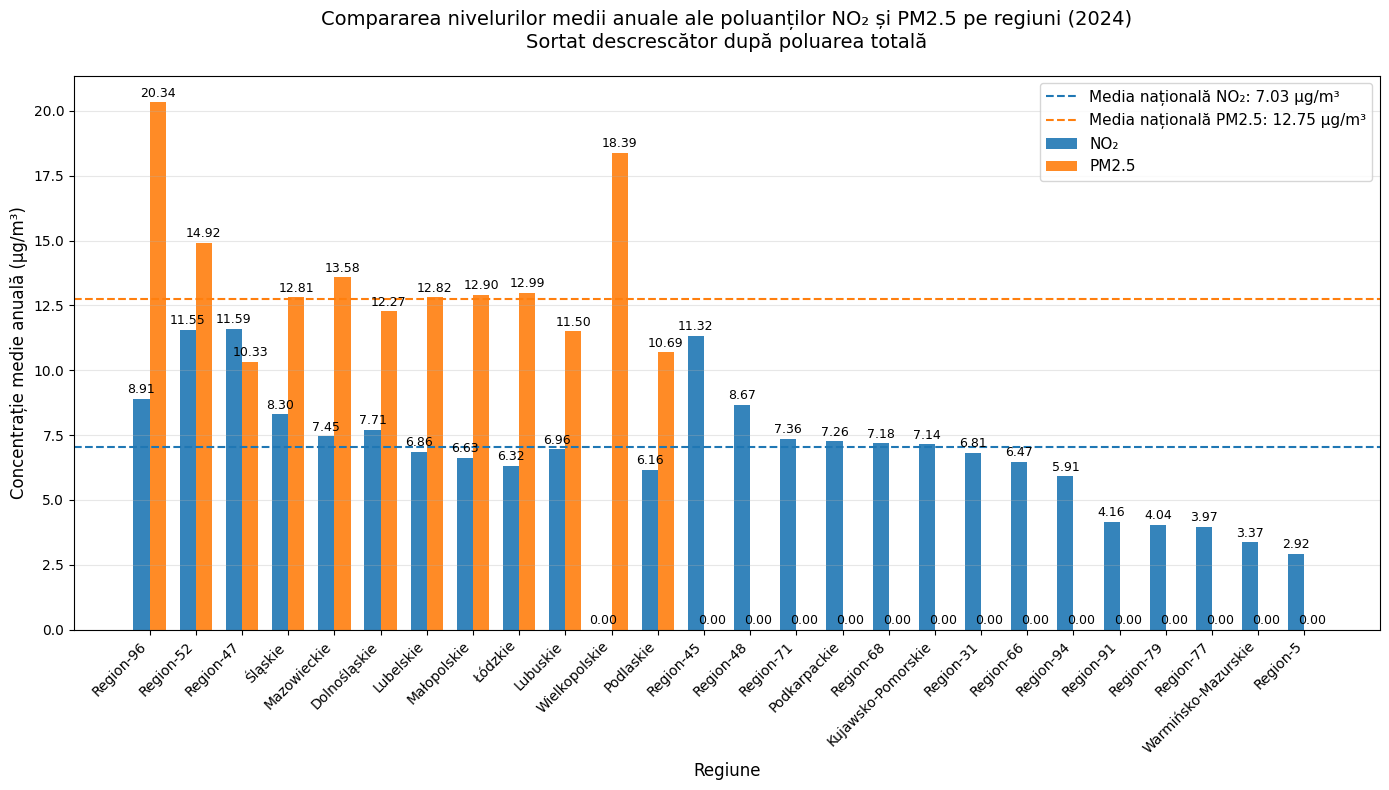

TABEL: Nivelurile medii anuale ale poluanților pe regiuni (µg/m³)
(Sortat descrescător după poluarea totală NO₂ + PM2.5)
species                NO2  PM2.5  Total (NO₂ + PM2.5)
region_name                                           
Region-96             8.91  20.34                29.25
Region-52            11.55  14.92                26.47
Region-47            11.59  10.33                21.92
Śląskie               8.30  12.81                21.11
Mazowieckie           7.45  13.58                21.03
Dolnośląskie          7.71  12.27                19.98
Lubelskie             6.86  12.82                19.68
Małopolskie           6.63  12.90                19.53
Łódzkie               6.32  12.99                19.31
Lubuskie              6.96  11.50                18.46
Wielkopolskie         0.00  18.39                18.39
Podlaskie             6.16  10.69                16.85
Region-45            11.32   0.00                11.32
Region-48             8.67   0.00                 8.67

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. Calcul medii pe regiune și poluant
# ============================================================

# Media pe regiune și poluant
region_pollutant_stats = (
    features_df
    .groupby(["region_name", "species"])["conc_raw_micrograms_per_m3"]
    .mean()
    .reset_index()
)

# Filtrăm doar NO2 și PM2.5
region_stats_filtered = region_pollutant_stats[
    region_pollutant_stats["species"].isin(["NO2", "PM2.5"])
]

# Pivot: regiuni pe rânduri, poluanți pe coloane
pivot_df = region_stats_filtered.pivot(
    index="region_name",
    columns="species",
    values="conc_raw_micrograms_per_m3"
).fillna(0)

# Rotunjim la 2 zecimale
pivot_df = pivot_df.round(2)

# Adăugăm o coloană cu poluarea totală (NO2 + PM2.5) pentru sortare
pivot_df["Total"] = pivot_df["NO2"] + pivot_df["PM2.5"]

# Sortăm regiunile descrescător după poluarea totală
pivot_df = pivot_df.sort_values("Total", ascending=False)

# Ștergem coloana auxiliară (nu o afișăm în tabelul final)
pivot_display = pivot_df[["NO2", "PM2.5"]].copy()

# ============================================================
# 2. Calcul medii naționale (pentru linii orizontale)
# ============================================================

national_means = features_df[features_df["species"].isin(["NO2", "PM2.5"])] \
    .groupby("species")["conc_raw_micrograms_per_m3"] \
    .mean()

no2_national = national_means.get("NO2", 0)
pm25_national = national_means.get("PM2.5", 0)

# ============================================================
# 3. Grafic bare grupate îmbunătățit
# ============================================================

regions = pivot_df.index
x = np.arange(len(regions))
width = 0.35

plt.figure(figsize=(14, 8))

# Barele
bars1 = plt.bar(x - width/2, pivot_df["NO2"], width, label="NO₂", color="#1f77b4", alpha=0.9)
bars2 = plt.bar(x + width/2, pivot_df["PM2.5"], width, label="PM2.5", color="#ff7f0e", alpha=0.9)

# Linii orizontale pentru mediile naționale
plt.axhline(y=no2_national, color="#1f77b4", linestyle="--", linewidth=1.5,
            label=f'Media națională NO₂: {no2_national:.2f} µg/m³')
plt.axhline(y=pm25_national, color="#ff7f0e", linestyle="--", linewidth=1.5,
            label=f'Media națională PM2.5: {pm25_national:.2f} µg/m³')

# Etichete cu valori deasupra barelor
for i, region in enumerate(regions):
    plt.text(x[i] - width/2, pivot_df["NO2"].iloc[i] + 0.1,
             f'{pivot_df["NO2"].iloc[i]:.2f}', ha='center', va='bottom', fontsize=9)
    plt.text(x[i] + width/2, pivot_df["PM2.5"].iloc[i] + 0.1,
             f'{pivot_df["PM2.5"].iloc[i]:.2f}', ha='center', va='bottom', fontsize=9)

# Setări grafic
plt.title("Compararea nivelurilor medii anuale ale poluanților NO₂ și PM2.5 pe regiuni (2024)\n"
          "Sortat descrescător după poluarea totală",
          fontsize=14, pad=20)
plt.xlabel("Regiune", fontsize=12)
plt.ylabel("Concentrație medie anuală (µg/m³)", fontsize=12)
plt.xticks(x, regions, rotation=45, ha='right', fontsize=10)
plt.legend(fontsize=11, loc='upper right')
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 4. Afișare tabel frumos (sortat la fel ca graficul)
# ============================================================

print("=" * 80)
print("TABEL: Nivelurile medii anuale ale poluanților pe regiuni (µg/m³)")
print("(Sortat descrescător după poluarea totală NO₂ + PM2.5)")
print("=" * 80)

# Adăugăm și coloana total pentru tabel
pivot_table = pivot_df[["NO2", "PM2.5"]].copy()
pivot_table["Total (NO₂ + PM2.5)"] = pivot_df["Total"]

print(pivot_table.round(2).to_string())
print("\nMedii naționale:")
print(f"NO₂:  {no2_national:.2f} µg/m³")
print(f"PM2.5: {pm25_national:.2f} µg/m³")
print("=" * 80)

==================================================================================================================

5.	Interpretarea Rezultatelor:

==================================================================================================================

◦	Scrieți un scurt rezumat al concluziilor, evidențiind tendințele, anomaliile sau modelele semnificative.

◦	Oferiți perspective despre cum aceste informații pot fi utilizate în politici de mediu sau pentru 
conștientizarea publicului.


Rezumat al concluziilor principale
------------------------------------

Analiza datelor privind calitatea aerului în Polonia pe parcursul anului 2024, concentrată pe poluanții NO₂ și PM2.5, evidențiază următoarele tendințe și modele semnificative:


- Tendințe sezoniere clare: Ambele poluante prezintă variații sezoniere pronunțate. Concentrațiile sunt semnificativ mai ridicate în sezonul rece (ianuarie–martie și octombrie–decembrie) și mai scăzute în sezonul cald (aprilie–septembrie).

  Media lunară maximă: decembrie (NO₂: 12.21 µg/m³, PM2.5: 22.06 µg/m³)

  Media lunară minimă: iunie–iulie (NO₂: ~4.4 µg/m³, PM2.5: ~6–7 µg/m³)

  Această tendință este tipică pentru Europa Centrală și este cauzată în principal de încălzirea rezidențială, condiții meteorologice favorabile stagnării poluanților și trafic intens.



- Vârfuri de poluare la sfârșitul anului: Săptămânile 45–52 și în special săptămâna 52 (sfârșit de decembrie) înregistrează cele mai înalte valori medii săptămânale (NO₂: 19.04 µg/m³, PM2.5: 38.85 µg/m³ în W52). Valorile zilnice din ultima parte a lunii decembrie arată creșteri accentuate (PM2.5 depășește frecvent 50 µg/m³ în zilele 27–28 decembrie), probabil influențate de condiții de inveresie termică și posibile emisii suplimentare (inclusiv sărbători).

- Niveluri generale moderate:

  Media anuală NO₂: 7.03 µg/m³ (relativ scăzută, sub limita anuală UE de 40 µg/m³)

  Media anuală PM2.5: 12.75 µg/m³ (aproape de limita anuală UE de 25 µg/m³, dar cu episoade frecvente de depășire zilnică a limitei de 25 µg/m³)
  


- Diferențe regionale importante: Există variații semnificative între regiuni. Cele mai poluate regiuni (poluare totală NO₂ + PM2.5 > 20 µg/m³) sunt Region-96, Region-52, Region-47, Śląskie, Mazowieckie și Dolnośląskie – majoritatea regiuni industriale sau puternic urbanizate. În schimb, unele regiuni (ex. Warmińsko-Mazurskie, anumite regiuni codificate) au valori mult mai scăzute sau lipsă de date pentru unul dintre poluanti.



- Anomalii și observații: PM2.5 prezintă o dispersie mai mare (deviație standard 11.02 vs 6.36 la NO₂) și valori maxime extreme (203.2 µg/m³), indicând episoade intense de poluare cu particule fine, probabil legate de arderea combustibililor solizi și condiții meteorologice.

Perspective și utilizare în politici de mediu și conștientizare publică
-------------------------------------------------------------------------------
Informațiile obținute din această analiză pot fi valorificate în mai multe direcții practice:

- Politici de mediu țintite:
Prioritizarea măsurilor în regiunile cele mai afectate (ex. Śląskie, Mazowieckie, Dolnośląskie) prin extinderea rețelei de monitorizare, introducerea zonelor cu emisii reduse (LEZ) și programe de înlocuire a sistemelor de încălzire pe cărbune/lemne.
Îmbunătățirea alertelor de poluare în sezonul rece, în special în decembrie–ianuarie, când riscul depășirilor este maxim.

- Conștientizare și educație publică:
Campanii de informare în perioadele critice (noiembrie–martie) care să explice legătura dintre încălzirea individuală, trafic și calitatea aerului.
Dezvoltarea de aplicații sau platforme publice care să afișeze în timp real datele agregate zilnice/săptămânale, similar cu cele generate în analiză, pentru a crește responsabilitatea cetățenilor.

- Monitorizare și raportare:
Datele confirmă necesitatea continuării și extinderii monitorizării PM2.5 (mai problematic decât NO₂ în multe regiuni).
Analizele periodice de tipul celei de față pot servi ca bază pentru raportarea către UE și evaluarea eficienței măsurilor implementate.



În concluzie, anul 2024 arată o situație general acceptabilă pentru NO₂, dar cu provocări persistente pentru PM2.5, în special în sezonul rece și în regiunile industriale. Acționarea rapidă asupra surselor de încălzire rezidențială și a traficului rămâne esențială pentru îmbunătățirea calității aerului și protejarea sănătății publice în Polonia.